In [19]:
import glob
import numpy as np
import matplotlib.pyplot as plt

import lal
from lalframe.utils import frtools

from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.psd import analytical
from pycbc.psd import analytical_space
from pycbc.noise import noise_from_psd

from bilby.core.prior.analytical import Uniform, Cosine, Sine
from bilby.gw.conversion import bilby_to_lalsimulation_spins

from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries

### Generate CBC parameters

In [3]:
# Generate bby_parameters from bilby
priors = dict()
priors['Mc'] = Uniform(25, 100, name='chrip mass', latex_label='Mc')
priors['q'] = Uniform(0.125, 1, name='mass ration', latex_label='q')
priors['a1'] = Uniform(0, 0.99, name='a1', latex_label='a1')
priors['a2'] = Uniform(0, 0.99, name='a2', latex_label='a2')
priors['tilt1'] = Sine(0, np.pi, name='tilt1', latex_label='tilt1')
priors['tilt2'] = Sine(0, np.pi, name='tilt2', latex_label='tilt2')
priors['phi12'] = Uniform(0, 2*np.pi, name='phi12', latex_label='phi12')
priors['phijl'] = Uniform(0, 2*np.pi, name='phijl', latex_label='phijl')
priors['thetajn'] = Sine(0, np.pi, name='thetajn', latex_label='thetajn')
priors['distance'] = Uniform(500, 3000, unit='Mpc', name='distance', latex_label='dL')
priors['phase'] = Uniform(0, 2*np.pi, name='phase', latex_label='phi')
priors['ra'] = Uniform(0, 2*np.pi, name='ra', latex_label='ra')
priors['dec'] = Cosine(-np.pi/2, np.pi/2, name='dec', latex_label='dec')
priors['psi'] = Uniform(0, 2*np.pi, name='psi', latex_label='psi')

waveform_params = {key:priors[key].sample(1)[0] for key in priors}
Mc = waveform_params['Mc']
q = waveform_params['q']
m1 = Mc*(1+q)**(1/5)*q**(-3/5)
m2 = Mc*(1+q)**(1/5)*q**(2/5)
while(m1 < 5 or m1 > 100 or m2 <5 or m2 > 100):
    inject_parameters = {key:priors[key].sample(1)[0] for key in ['Mc', 'q']}
    Mc = inject_parameters['Mc']
    q = inject_parameters['q']
    m1 = Mc*(1+q)**(1/5)*q**(-3/5)
    m2 = Mc*(1+q)**(1/5)*q**(2/5)

Mc = waveform_params['Mc']
q = waveform_params['q']
waveform_params['mass1'] = Mc*(1+q)**(1/5)*q**(-3/5)
waveform_params['mass2'] = Mc*(1+q)**(1/5)*q**(2/5)
waveform_params['f_ref'] = 10
lal_spins = bilby_to_lalsimulation_spins(
    theta_jn=waveform_params['thetajn'],
    phi_jl=waveform_params['phijl'],
    tilt_1=waveform_params['tilt1'],
    tilt_2=waveform_params['tilt2'],
    phi_12=waveform_params['phi12'],
    a_1=waveform_params['a1'],
    a_2=waveform_params['a2'],
    mass_1=waveform_params['mass1']*lal.MSUN_SI,
    mass_2=waveform_params['mass2']*lal.MSUN_SI,
    reference_frequency=waveform_params['f_ref'],
    phase=waveform_params['phase'],
)
waveform_params['inclination'] = lal_spins[0]
waveform_params['spin1x'] = lal_spins[1]
waveform_params['spin1y'] = lal_spins[2]
waveform_params['spin1z'] = lal_spins[3]
waveform_params['spin2x'] = lal_spins[4]
waveform_params['spin2y'] = lal_spins[5]
waveform_params['spin2z'] = lal_spins[6]
waveform_params['approximant'] = "IMRPhenomPv2"

In [4]:
print(waveform_params)

{'Mc': np.float64(37.892018940085826), 'q': np.float64(0.9067006901677571), 'a1': np.float64(0.164640918950191), 'a2': np.float64(0.8405576268963231), 'tilt1': np.float64(2.602697985066621), 'tilt2': np.float64(1.6520970491698106), 'phi12': np.float64(3.652104247192054), 'phijl': np.float64(1.0780886167833335), 'thetajn': np.float64(1.2424867637881527), 'distance': np.float64(780.216933775167), 'phase': np.float64(4.773602306406191), 'ra': np.float64(1.7199255443805455), 'dec': np.float64(0.8291389213440827), 'psi': np.float64(0.45752393300677563), 'mass1': np.float64(45.72206983827198), 'mass2': np.float64(41.45623227825959), 'f_ref': 10, 'inclination': 1.1069921228212443, 'spin1x': -0.03350162733580485, 'spin1y': 0.07756600629566424, 'spin1z': -0.141307423109889, 'spin2x': 0.6656363541856922, 'spin2y': -0.5087293721949938, 'spin2z': -0.06826268370086973, 'approximant': 'IMRPhenomPv2'}


### Generate Waveforms

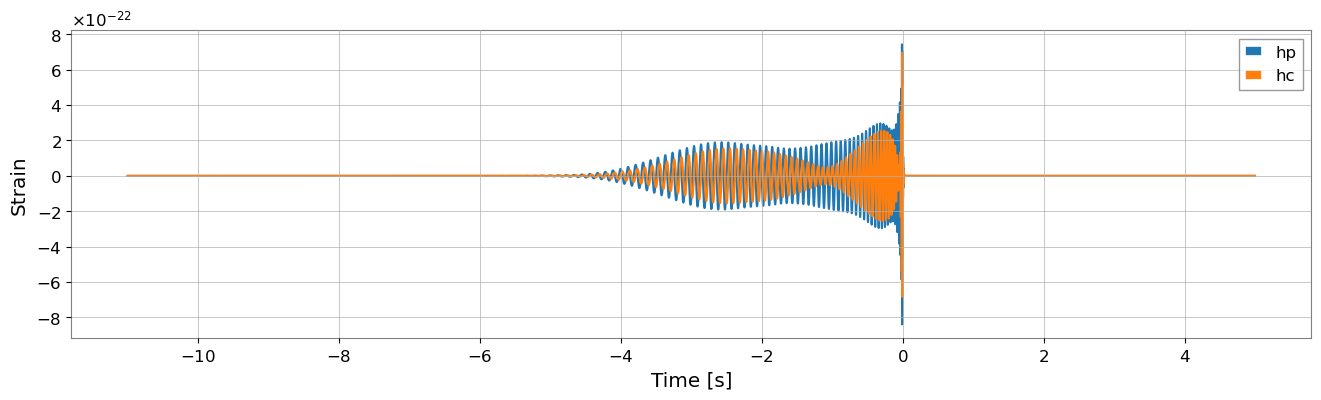

In [5]:
sample_rate = 4096
f_lower = 10
hp, hc = get_td_waveform(
    approximant=waveform_params['approximant'],
    delta_t=1/sample_rate,
    f_lower=f_lower,
    f_ref=waveform_params['f_ref'],
    mass1=waveform_params['mass1'],
    mass2=waveform_params['mass2'],
    spin1x=waveform_params['spin1x'],
    spin1y=waveform_params['spin1y'],
    spin1z=waveform_params['spin1z'],
    spin2x=waveform_params['spin2x'],
    spin2y=waveform_params['spin2y'],
    spin2z=waveform_params['spin2z'],
    distance=waveform_params['distance'],
    coa_phase=waveform_params['phase'],
    inclination=waveform_params['inclination'],
)

plt.figure(figsize=[16,4])
plt.plot(hp.sample_times, hp, label='hp')
plt.plot(hc.sample_times, hc, label='hc')
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'figs/BBH-H1.png'

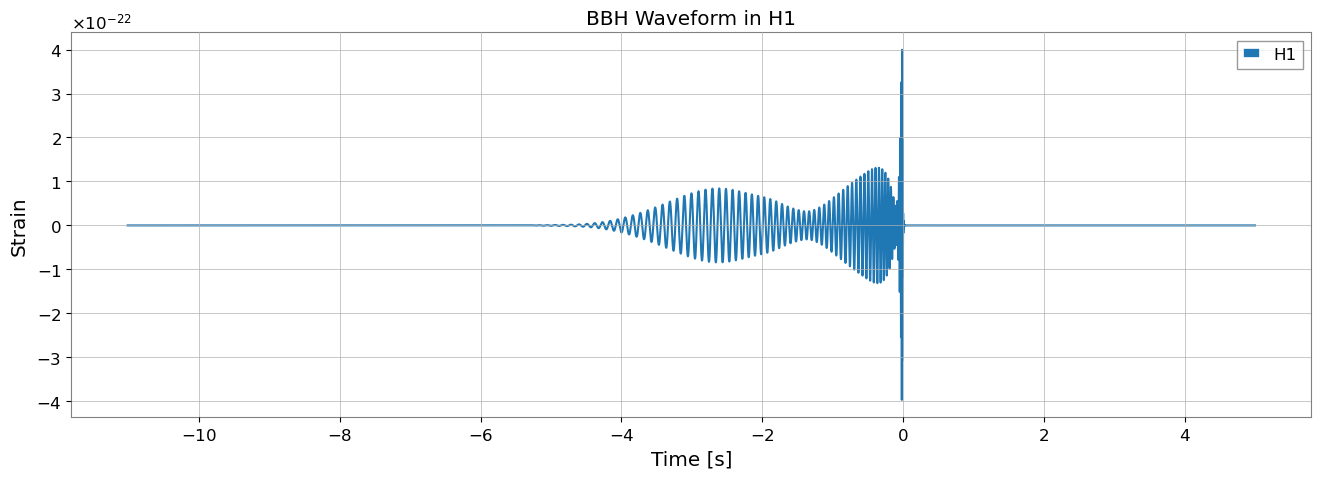

In [10]:
ifos = ['H1', 'L1', 'V1', 'K1']
signals = dict.fromkeys(ifos)
for ifo in ifos:
    signal = Detector(ifo).project_wave(
        hp=hp,
        hc=hc,
        ra=waveform_params['ra'],
        dec=waveform_params['dec'],
        polarization=waveform_params['psi'],
    )
    signals[ifo] = signal


for ifo in ifos[:1]:
    plt.figure(figsize=[16,5])
    plt.title(f"BBH Waveform in {ifo}")
    plt.plot(signals[ifo].sample_times, signals[ifo], label=ifo)
    plt.xlabel("Time [s]")
    plt.ylabel("Strain")
    plt.legend()
    plt.savefig(f"figs/BBH-{ifo}.png")
    plt.show()


### Generate Noise

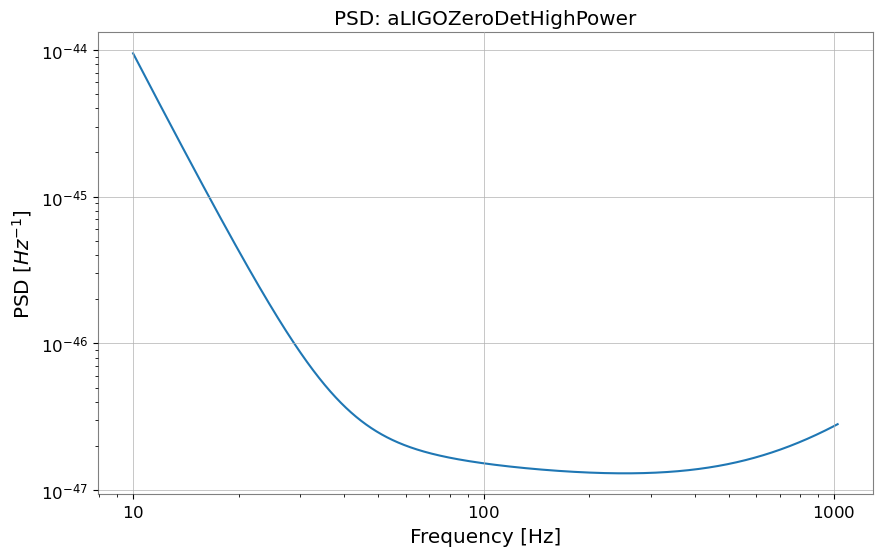

In [11]:
sample_rate = 8192
delta_f = 1/64
low_freq_cutoff = 1
length = int((sample_rate - low_freq_cutoff) / delta_f)
psd = analytical.aLIGOZeroDetHighPower(
    length=length,
    delta_f=delta_f,
    low_freq_cutoff=low_freq_cutoff,
)

psd_model = "aLIGOZeroDetHighPower"
f_st, f_ed = 10, 1024
plt.figure(figsize=[10,6])
plt.title(f"PSD: {psd_model}")
plt.plot(psd.sample_frequencies[int(f_st/delta_f):int(f_ed/delta_f)], psd[int(f_st/delta_f):int(f_ed/delta_f)])
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [$Hz^{-1}$]")
plt.xscale('log')
plt.yscale('log')
# plt.xlim([low_freq_cutoff, sample_rate/2])
plt.show()

229376 294912


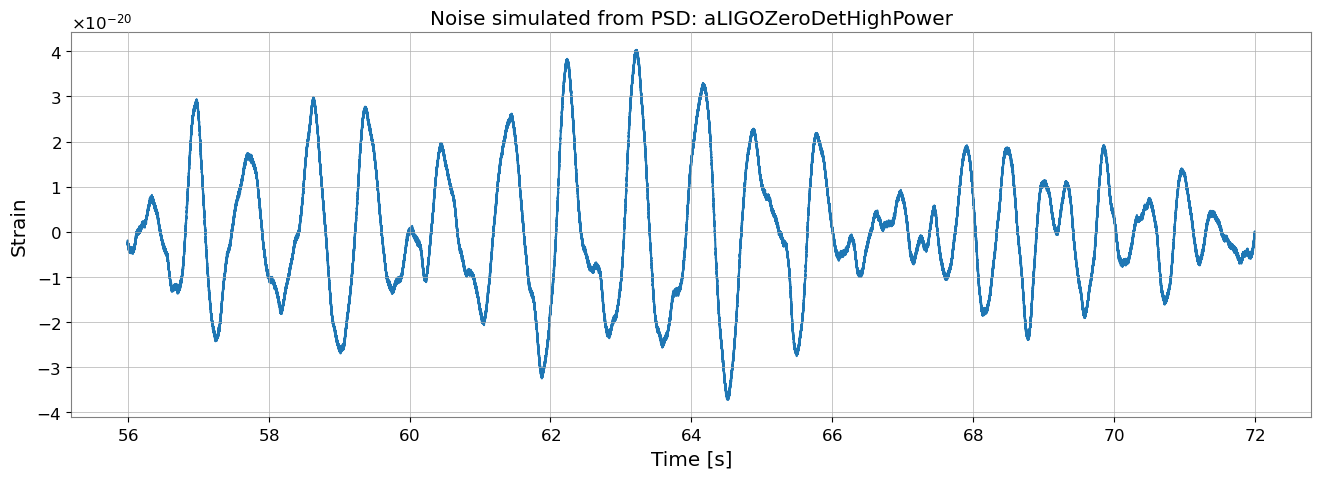

In [12]:
sample_rate = 4096
length = 128 * sample_rate
delta_t = 1/sample_rate
noise = noise_from_psd(
    length=length,
    delta_t=delta_t,
    psd=psd,
    # seed=5538,
    seed=938,
)

st, ed = int((noise.duration/2 - 8)*noise.sample_rate), int((noise.duration/2 + 8)*noise.sample_rate)
print(st, ed)
plt.figure(figsize=[16,5])
plt.title(f"Noise simulated from PSD: {psd_model}")
plt.plot(noise.sample_times[st:ed], noise[st:ed])
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.show()

In [13]:
n_prepend = int(np.round((float(signal.start_time) + float(noise.duration)/2)*sample_rate))
n_append = int(np.round((float(noise.duration)/2 - float(signal.end_time))*sample_rate))
signal.prepend_zeros(n_prepend)
signal.append_zeros(n_append)
signal.start_time = noise.start_time

data = noise + signal
highpass_data = data.highpass_fir(20, 4*sample_rate)
crop_signal = signal.crop(4, 4)

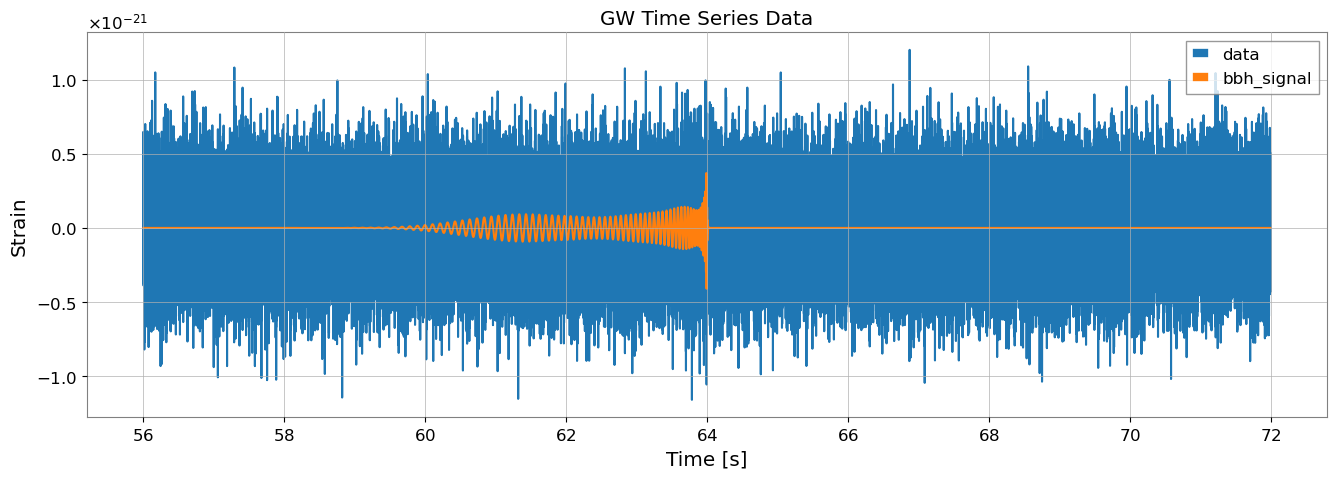

In [14]:
st, ed = int((highpass_data.duration/2 - 8)*sample_rate), int((highpass_data.duration/2 + 8)*sample_rate)
plt.figure(figsize=[16,5])
plt.title("GW Time Series Data")
plt.plot(highpass_data.sample_times[st:ed], highpass_data[st:ed], label='data')
plt.plot(crop_signal.sample_times[st:ed], crop_signal[st:ed], label='bbh_signal')
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend()
plt.show()

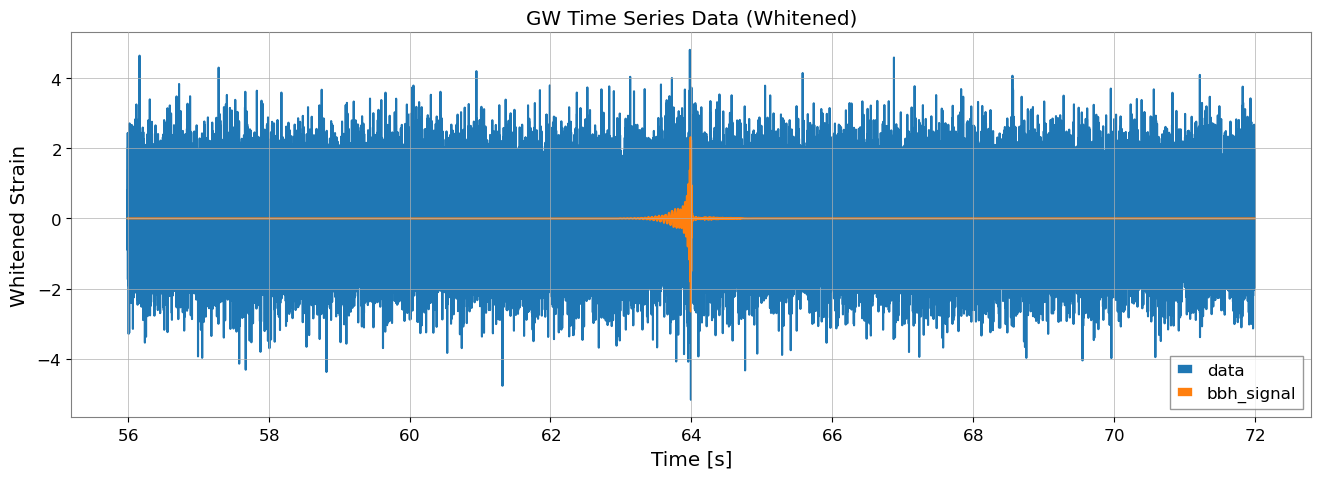

In [15]:
t0 = float(data.start_time)
data_ts = TimeSeries(
    data.data,
    t0=t0,
    sample_rate=sample_rate,
)
noise_ts = TimeSeries(
    noise.data,
    t0=t0,
    sample_rate=sample_rate,
)
signal_ts = TimeSeries(
    signal.data,
    t0=t0,
    sample_rate=sample_rate,
)

fftlength = 32
overlap = fftlength/2
asd = noise_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)
wh_data = data_ts.whiten(
    asd=asd,
    highpass=20,
)
wh_signal = signal_ts.whiten(
    asd=asd,
    highpass=20,
)

st, ed = int((wh_data.duration.value/2 - 8)*sample_rate), int((wh_data.duration.value/2 + 8)*sample_rate)
plt.figure(figsize=[16,5])
plt.title("GW Time Series Data (Whitened)")
plt.plot(wh_data.times[st:ed], wh_data[st:ed], label='data')
plt.plot(wh_signal.times[st:ed], wh_signal[st:ed], label='bbh_signal')
plt.xlabel("Time [s]")
plt.ylabel("Whitened Strain")
plt.legend()
plt.show()

SNR: 38.59819201822426


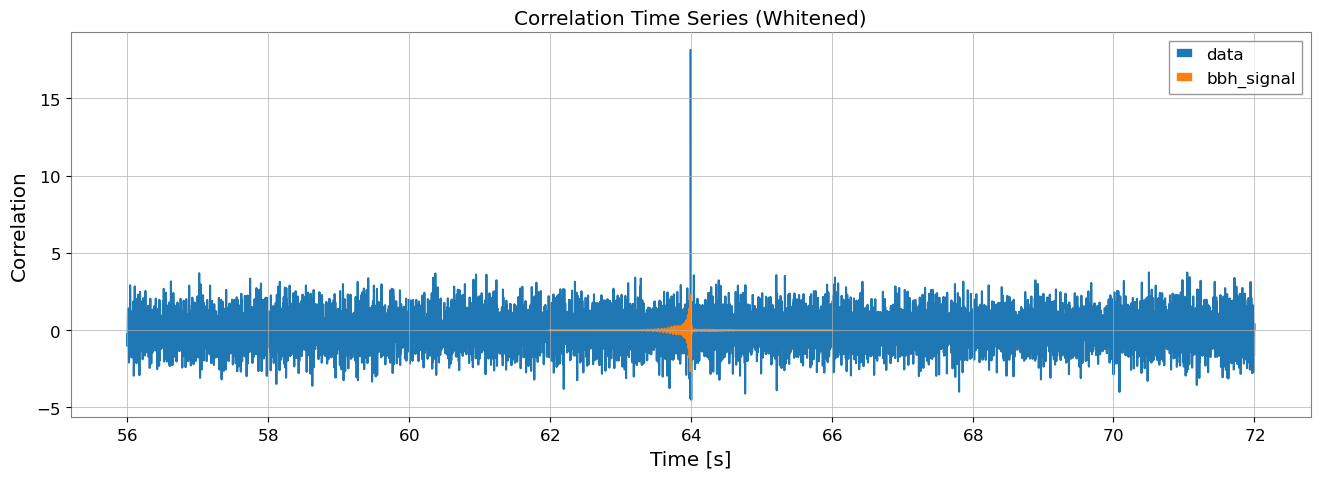

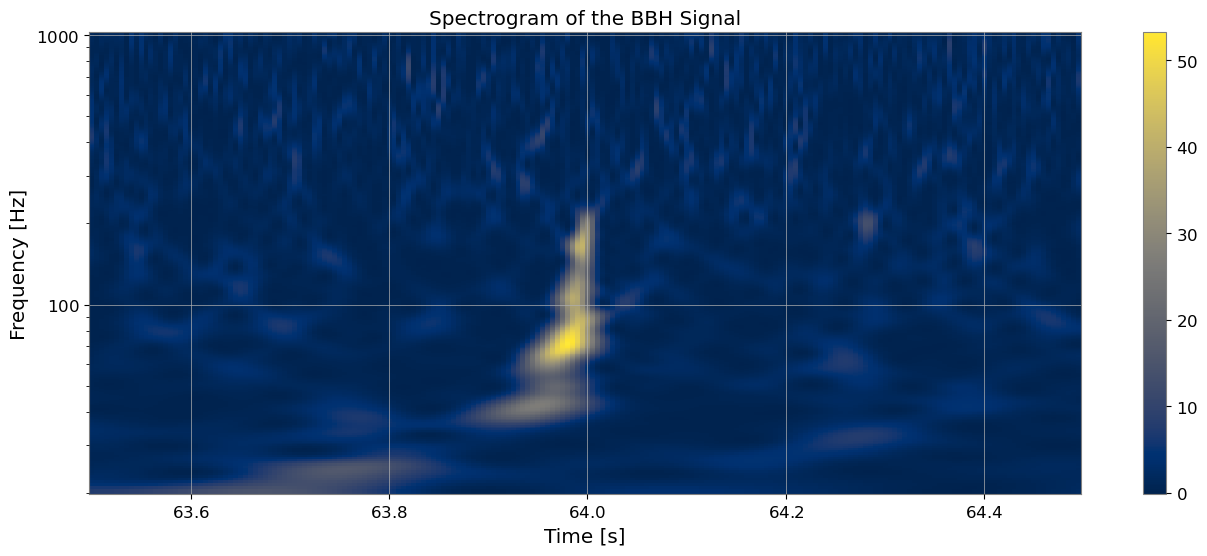

In [16]:
temp_st, temp_ed = int(wh_signal.duration.value/2 - 2)*sample_rate, int(wh_signal.duration.value/2 + 2)*sample_rate
template = wh_signal[temp_st:temp_ed]
corr_ts = wh_data.correlate(template)

# Estimate SNR:
sig_template = signal_ts[temp_st:temp_ed]
flow, fhigh = 20, 1024
asd = asd.interpolate(1/sig_template.duration.value)
template_f = sig_template.fft()
template_f = template_f/template_f.df
snrf = template_f.conj()*template_f/asd**2
snr = 4*snrf[int(flow/snrf.df.value):int(fhigh/snrf.df.value)].real.sum()*snrf.df
snr = snr.to_value()**0.5
print(f"SNR: {snr}")

st, ed = int((wh_data.duration.value/2 - 8)*sample_rate), int((wh_data.duration.value/2 + 8)*sample_rate)
st2, ed2 = int((wh_data.duration.value/2 - 2)*sample_rate), int((wh_data.duration.value/2 + 2)*sample_rate)
plt.figure(figsize=[16,5])
plt.title("Correlation Time Series (Whitened)")
plt.plot(corr_ts.times[st:ed], corr_ts[st:ed], label='data')
plt.plot(wh_signal.times[st2:ed2], wh_signal[st2:ed2], label='bbh_signal')
plt.xlabel("Time [s]")
plt.ylabel("Correlation")
plt.legend()
plt.show()

# Q-transform
q_ts = wh_data[st:ed]
q_spec = q_ts.q_transform(
    qrange=(15,15),
    frange=(20,1024),
    tres=1/200,
    logf=False,
    fres=0.5,
    whiten=False,
)
crop_head = q_ts.t0.value + q_ts.duration.value/2 - 0.5
crop_tail = q_ts.t0.value + q_ts.duration.value/2 + 0.5
q_spec = q_spec.crop(crop_head, crop_tail)
amplitude = q_spec.T.to_value()
times = q_spec.times.to_value()
frequencies = q_spec.frequencies.to_value()
plt.figure(figsize=[16,6])
plt.title(f"Spectrogram of the BBH Signal")
plt.pcolormesh(
    times,
    frequencies,
    amplitude,
    cmap='cividis',
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.yscale('log')
plt.colorbar(cmap='cividis')
plt.show()

### Real Noise

In [21]:
ifo = "H1"
seg_st, seg_ed = 1266280137, 1266359523
ts_st = seg_st + 1800
ts_ed = ts_st + 128
data_dir = "./Data"
source = glob.glob(f"{data_dir}/{ifo[0]}*.gwf")
print(source)
channel = frtools.get_channels(source[0])[0]
print(channel)
ts = TimeSeries.read(
    source=source,
    channel=channel,
)
print(ts)

['./Data/H-H1_GWOSC_O3b_4KHZ_R1-1266281937-128.gwf']
H1:GWOSC-4KHZ_R1_STRAIN
TimeSeries([-3.45428241e-20, -3.17864249e-20, -7.06381359e-21,
            ...,  1.75740507e-20, -1.75512907e-21,
             4.96617858e-21]
           unit: dimensionless,
           t0: 1266281937.0 s,
           dt: 0.000244140625 s,
           name: H1:GWOSC-4KHZ_R1_STRAIN,
           channel: H1:GWOSC-4KHZ_R1_STRAIN)


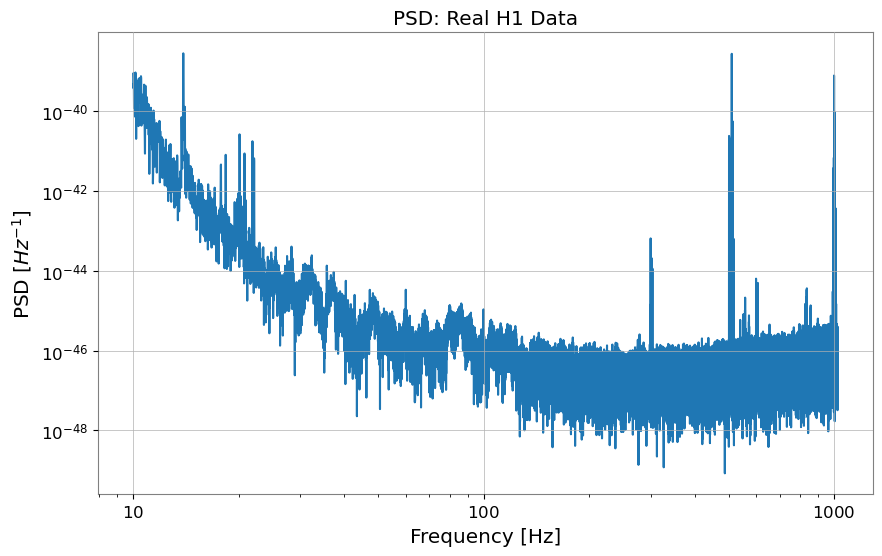

In [23]:
fftlength = 64
overlap = fftlength/2
ts_psd = ts.psd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)

psd_model = "Real H1 Data"
f_st, f_ed = int(10/ts_psd.df.value), int(1024/ts_psd.df.value)
fig_dir = "./Figs"
plt.figure(figsize=[10,6])
plt.title(f"PSD: {psd_model}")
plt.plot(ts_psd[f_st:f_ed].frequencies, ts_psd[f_st:f_ed])
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [$Hz^{-1}$]")
plt.xscale('log')
plt.yscale('log')
# plt.xlim([low_freq_cutoff, sample_rate/2])
plt.savefig(f"{fig_dir}/PSD_{ifo}-{int(ts.t0.value)}-{int(ts.duration.value)}.png")
plt.show()

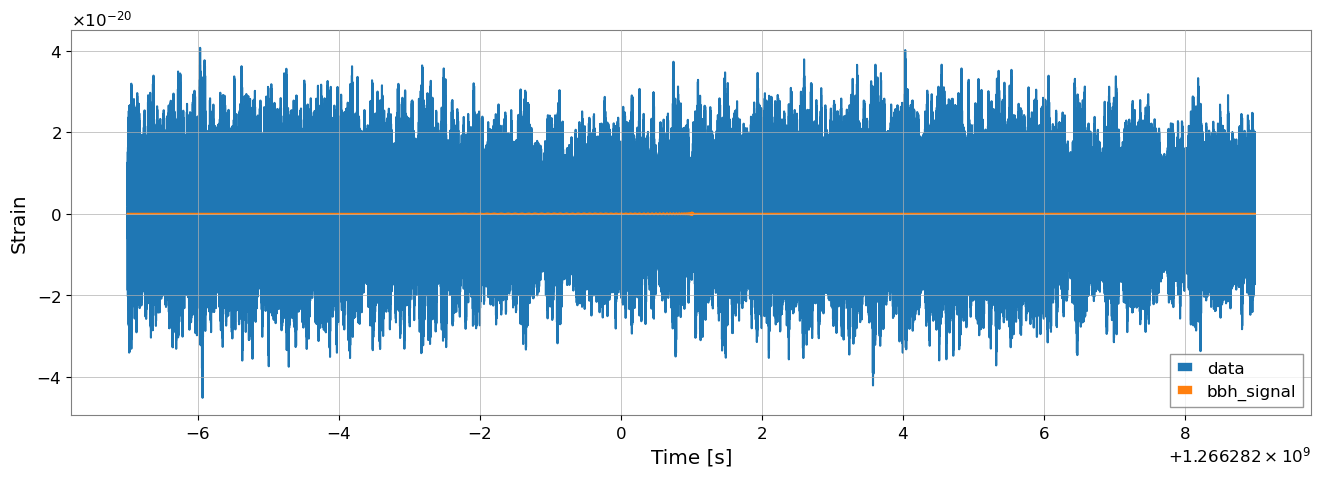

In [206]:
signal_ts = TimeSeries(
    signal.data,
    t0=ts.t0,
    sample_rate=sample_rate,
)
data_ts = ts.inject(signal_ts)

highpass_ts = data_ts.highpass(20)
st, ed = int((highpass_ts.duration.value/2 - 8)*sample_rate), int((highpass_ts.duration.value/2 + 8)*sample_rate)
plt.figure(figsize=[16,5])
plt.plot(highpass_ts.times[st:ed], highpass_ts[st:ed], label='data')
plt.plot(signal_ts.times[st:ed], signal_ts[st:ed], label='bbh_signal')
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend()
plt.savefig(f"figs/BBH-{ifo}.png")
plt.show()

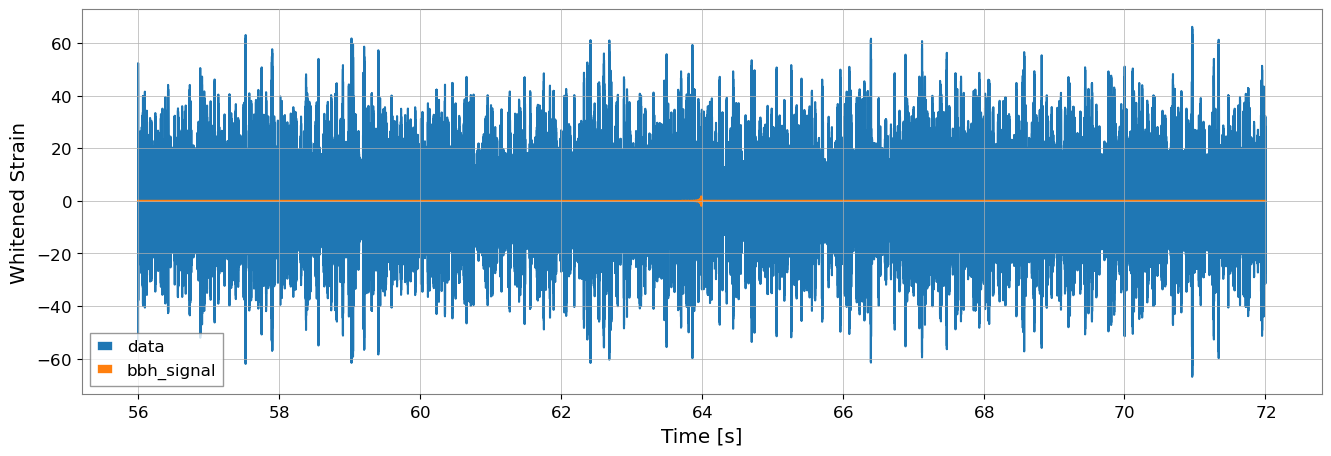

In [24]:
fftlength = 32
overlap = fftlength/2
asd = ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)
wh_data_ts = data_ts.whiten(
    asd=asd,
    highpass=20,
)
wh_signal_ts = signal_ts.whiten(
    asd=asd,
    highpass=20,
)

st, ed = int((wh_data_ts.duration.value/2 - 8)*sample_rate), int((wh_data_ts.duration.value/2 + 8)*sample_rate)
plt.figure(figsize=[16,5])
plt.plot(wh_data_ts.times[st:ed], wh_data_ts[st:ed], label='data')
plt.plot(wh_signal_ts.times[st:ed], wh_signal_ts[st:ed], label='bbh_signal')
plt.xlabel("Time [s]")
plt.ylabel("Whitened Strain")
plt.legend()
plt.savefig(f"{fig_dir}/BBH_whiten_ts_{ifo}.png")
plt.show()

SNR: 22.73896207371181


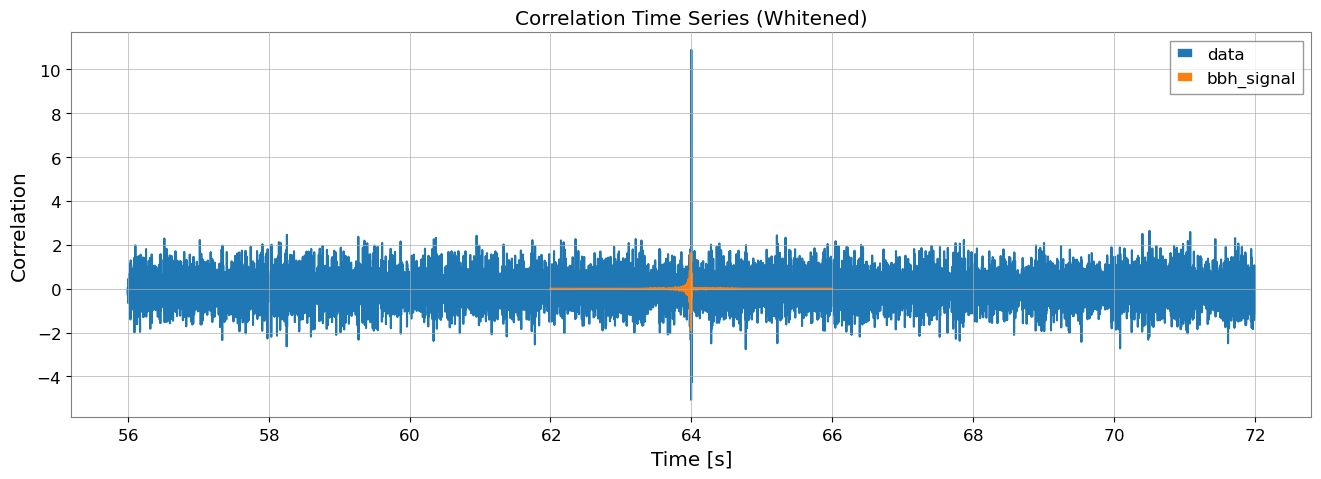

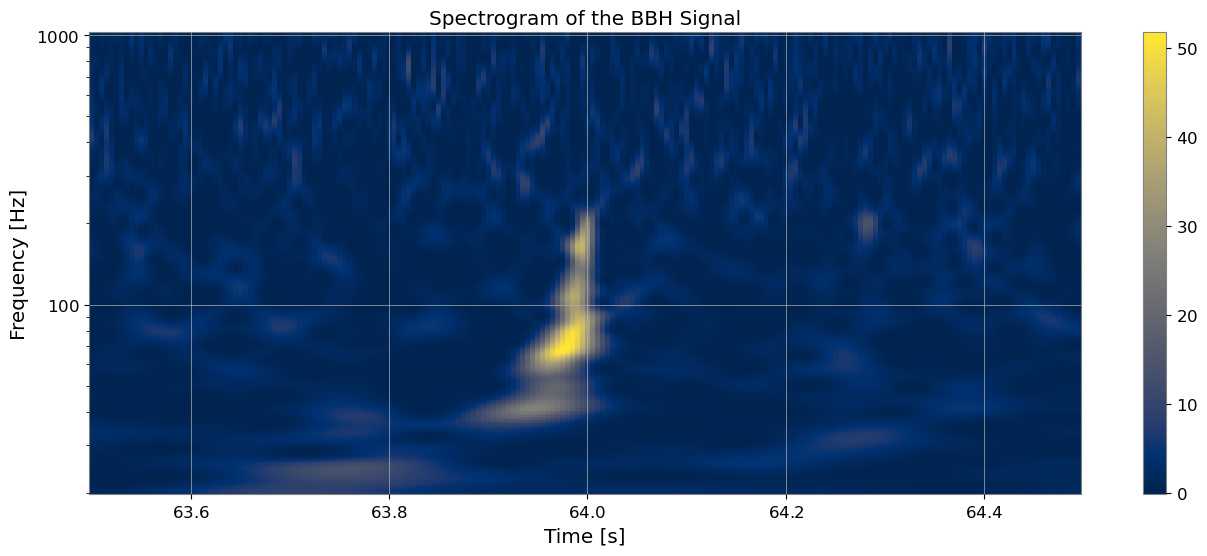

In [25]:
temp_st, temp_ed = int(wh_signal_ts.duration.value/2 - 2)*sample_rate, int(wh_signal_ts.duration.value/2 + 2)*sample_rate
template_ts = wh_signal_ts[temp_st:temp_ed]
corr_ts = wh_data_ts.correlate(template_ts)

# Estimate SNR:
sig_template = signal_ts[temp_st:temp_ed]
flow, fhigh = 20, 1024
asd = asd.interpolate(1/sig_template.duration.value)
template_f = sig_template.fft()
template_f = template_f/template_f.df
snrf = template_f.conj()*template_f/asd**2
snr = 4*snrf[int(flow/snrf.df.value):int(fhigh/snrf.df.value)].real.sum()*snrf.df
snr = snr.to_value()**0.5
print(f"SNR: {snr}")

# st, ed = 0, int(wh_data_ts.duration.value*sample_rate)
st, ed = int((wh_data_ts.duration.value/2 - 8)*sample_rate), int((wh_data_ts.duration.value/2 + 8)*sample_rate)
st2, ed2 = int((wh_data.duration.value/2 - 2)*sample_rate), int((wh_data.duration.value/2 + 2)*sample_rate)
plt.figure(figsize=[16,5])
plt.title("Correlation Time Series (Whitened)")
plt.plot(corr_ts.times[st:ed], corr_ts[st:ed], label='data')
plt.plot(wh_signal_ts.times[st2:ed2], wh_signal_ts[st2:ed2], label='bbh_signal')
plt.xlabel("Time [s]")
plt.ylabel("Correlation")
plt.legend()
plt.savefig(f"{fig_dir}/Correlation_ts_{ifo}.png")
plt.show()

# Q-transform
q_ts = wh_data_ts[st:ed]
q_spec = q_ts.q_transform(
    qrange=(15,15),
    frange=(20,1024),
    tres=1/200,
    logf=False,
    fres=0.5,
    whiten=False,
)
crop_head = q_ts.t0.value + q_ts.duration.value/2 - 0.5
crop_tail = q_ts.t0.value + q_ts.duration.value/2 + 0.5
q_spec = q_spec.crop(crop_head, crop_tail)
amplitude = q_spec.T.to_value()
times = q_spec.times.to_value()
frequencies = q_spec.frequencies.to_value()
plt.figure(figsize=[16,6])
plt.title(f"Spectrogram of the BBH Signal")
plt.pcolormesh(
    times,
    frequencies,
    amplitude,
    cmap='cividis',
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.yscale('log')
plt.colorbar(cmap='cividis')
plt.savefig(f"{fig_dir}/Spectrogram_{ifo}.png")
plt.show()

### Glitch

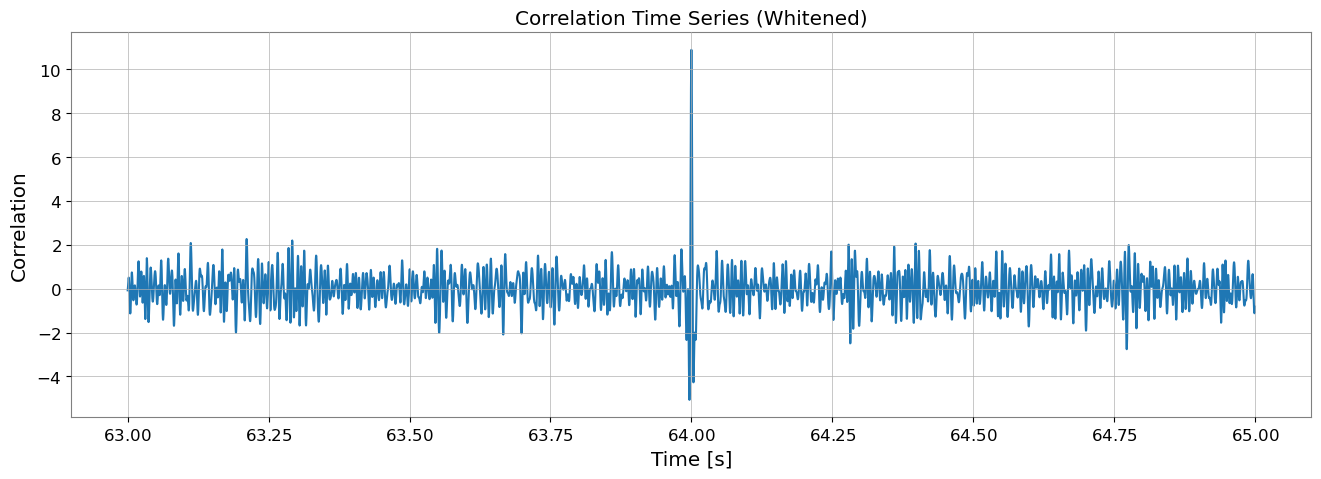

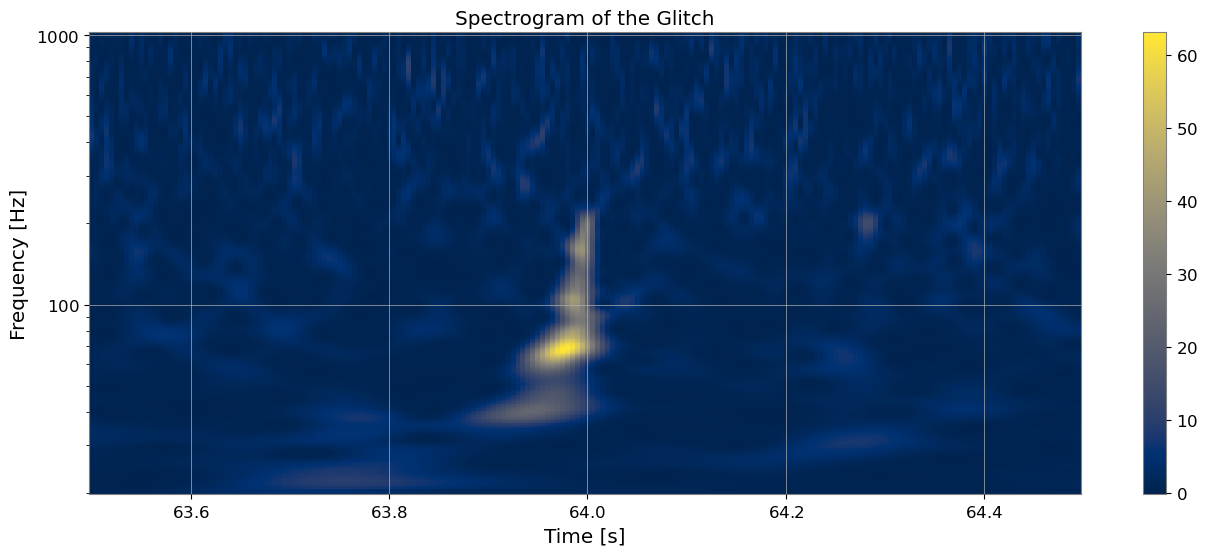

In [27]:
st = int(corr_ts.argmax() - 1*corr_ts.sample_rate.value)
ed = int(corr_ts.argmax() + 1*corr_ts.sample_rate.value)
plt.figure(figsize=[16,5])
plt.title("Correlation Time Series (Whitened)")
plt.plot(corr_ts.times[st:ed], corr_ts[st:ed], label='data')
plt.xlabel("Time [s]")
plt.ylabel("Correlation")
plt.savefig(f"{fig_dir}/Gltich_{ifo}.png")
plt.show()

# Q-transform
glitch_ts = wh_data_ts[st:ed]
q_spec = glitch_ts.q_transform(
    qrange=(15,15),
    frange=(20,1024),
    tres=1/200,
    logf=False,
    fres=0.5,
    whiten=False,
)
crop_head = glitch_ts.t0.value + glitch_ts.duration.value/2 - 0.5
crop_tail = glitch_ts.t0.value + glitch_ts.duration.value/2 + 0.5
q_spec = q_spec.crop(crop_head, crop_tail)
amplitude = q_spec.T.to_value()
times = q_spec.times.to_value()
frequencies = q_spec.frequencies.to_value()
plt.figure(figsize=[16,6])
plt.title(f"Spectrogram of the Glitch")
plt.pcolormesh(
    times,
    frequencies,
    amplitude,
    cmap='cividis',
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.yscale('log')
plt.colorbar(cmap='cividis')
plt.savefig(f"{fig_dir}/Spectrogram_Glitch_{ifo}.png")
plt.show()